<a href="https://colab.research.google.com/github/mr-nudo/intelligent-tools/blob/master/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [82]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Lambda, Average
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import random

# Set random seed

In [83]:
# Set environment variables
os.environ['PYTHONHASHSEED'] = str(25)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Set seed values
np.random.seed(25)
tf.random.set_seed(25)
random.seed(25)

# TODO: Preprocess

In [84]:
# Preprocess the text
def preprocess(text):
    lowercase_text = text.lower()
    words = lowercase_text.split()
    # words = [word for word in words if word.isalpha()]
    return words


# TODO: Build Vocabulary and training data

In [85]:
# Build vocabulary and generate training data
def build_and_prepare_data(words, window_size):
    # Build vocabulary
    # vocab = {}
    # word_index = 0  # Index for unique words
    # for word in set(words):
    #     vocab[word] = word_index
    #     word_index += 1
    # vocab_size = len(vocab)
    # # word_to_index = {v: k for k, v in vocab.items()}

    # # Generate context-target pairs
    # contexts = []
    # targets = []
    # for i in range(window_size, len(words) - window_size):
    #     context = words[i - window_size:i] + words[i + 1:i + window_size + 1]
    #     target = words[i]
    #     contexts.append(context)
    #     targets.append(target)

    vocab = set(words)
    word_to_index = {word: index for index, word in enumerate(vocab)}

    contexts = []
    targets = []
    for i in range(window_size, len(words) - window_size):
        context = [word_to_index[words[i - j]] for j in range(1, window_size + 1)] + \
                  [word_to_index[words[i + j]] for j in range(1, window_size + 1)]
        target = word_to_index[words[i]]
        contexts.append(context)
        targets.append(target)

    # contexts2 = []
    # targets2 = []
    # for i in range(window_size, len(words) - window_size):
    #     context2 = words[i - window_size:i] + words[i + 1:i + window_size + 1]
    #     target2 = words[i]
    #     contexts2.append(context2)
    #     targets2.append(target2)

    # Extract contexts and targets from data
    # contexts = [word_to_index[word] for word in contexts]
    # targets = [word_to_index[target] for target in targets]
    contexts = np.array(contexts)
    targets = np.array(targets)
    # contexts2 = np.array(contexts2)
    # targets2 = np.array(targets2)

    # print(contexts.shape)
    # print(targets.shape)
    # print(contexts2.shape)
    # print(targets2.shape)

    # Prepare contexts and targets for training by padding and one-hot encoding
    max_context_len = max(len(context) for context in contexts)
    contexts = pad_sequences(contexts, maxlen=max_context_len, padding='post')
    targets = to_categorical(targets, num_classes=len(vocab))

    return vocab, contexts, targets

# TODO: Build CBOW model

In [86]:
# Define CBOW model function
def build_cbow_model(vocab_size, embed_size, window_size):
    # Define the model architecture
    # inputs = Input(shape=(window_size,))

    # # Embedding layer to convert words into vectors
    # embeddings = Embedding(vocab_size, embed_size)(inputs)

    # # Average layer to combine context word vectors
    # average = Average()(embeddings)

    # # Output layer with softmax for predicting target word
    # outputs = Dense(vocab_size, activation='softmax')(average)

    # # Compiling model
    # model = tf.keras.Model(inputs=inputs, outputs=outputs)
    # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    #------------------------------------#

    # Total context size is 2 * window_size (context words on each side of the target word)
    context_size = 2 * window_size

    # Define input layer
    input_layer = Input(shape=(context_size,), dtype='int32', name='context_words')

    # Define embedding layer
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=context_size, name='embedding')
    embedded_context = embedding_layer(input_layer)

    # Average the embeddings
    averaging_layer = Lambda(lambda x: tf.reduce_mean(x, axis=1), name='averaging')
    averaged_context = averaging_layer(embedded_context)

    # Define output layer with softmax activation
    output_layer = Dense(vocab_size, activation='softmax', name='output')
    output = output_layer(averaged_context)

    # Build the model
    model = Model(inputs=input_layer, outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Print model summary
    model.summary()

    return model

# TODO: Set file path

In [87]:
# import file path
# from google.colab import drive
# drive.mount('/content/drive')
file_path = '/content/small_corpus.txt'

# Running the helper functions

In [88]:
# Read the file
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

words = preprocess(text)

# Print vocabulary size
print(f"Number of words: {len(words)}")

# Model parameters
window_size = 2

# Prepare dataset
vocab, contexts, targets = build_and_prepare_data(words, window_size)

vocab_size = len(vocab)
# Print vocabulary size
print(f"Vocabulary size: {vocab_size}")

# Print lengths of contexts and targets
print(f"Length of contexts array: {len(contexts)}")
print(f"Length of targets array: {len(targets)}")

Number of words: 280000
Vocabulary size: 28
Length of contexts array: 279996
Length of targets array: 279996


# Split the data inton training and validation sets

In [89]:
# Splitting the data
contexts_train, contexts_val, targets_train, targets_val = train_test_split(contexts, targets, test_size=0.2, random_state=25)

embed_size = 2

# Train the model

In [90]:
# Create and train the model
model = build_cbow_model(vocab_size, embed_size, window_size)
history = model.fit(contexts_train, targets_train, validation_data=(contexts_val, targets_val), epochs=7, verbose=1)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 context_words (InputLayer)  [(None, 4)]               0         
                                                                 
 embedding (Embedding)       (None, 4, 2)              56        
                                                                 
 averaging (Lambda)          (None, 2)                 0         
                                                                 
 output (Dense)              (None, 28)                84        
                                                                 
Total params: 140 (560.00 Byte)
Trainable params: 140 (560.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/7
7000/7000 [==============================] - 17s 2ms/step - loss: 2.3490 - accuracy: 0.1186 - val_loss: 2.2218 - val_accuracy: 0.1339
Epoch 2/7

# TODO: Visualise the Training and Validation loss

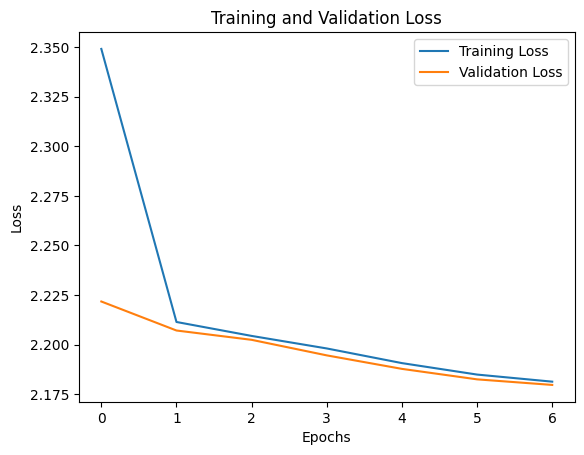

In [91]:
# Plotting the training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# TODO: Extract the embeddings

In [92]:
# Extract embeddings
embeddings = model.get_layer('embedding').get_weights()[0]

# TODO: Find similar words

In [93]:
def cosine_similarity(vec_a, vec_b):
    """Calculate the cosine similarity between two vectors."""
    dot_product = np.dot(vec_a, vec_b)
    norm_vec_a = np.linalg.norm(vec_a)
    norm_vec_b = np.linalg.norm(vec_b)
    similarity = dot_product / (norm_vec_a * norm_vec_b)
    return similarity

def find_similar_words(query_word, vocab, embeddings, top_n=3):
    """Find the top_n words most similar to the query_word based on the embeddings."""

    if isinstance(vocab, set):
        vocab = list(vocab)

    query_index = vocab.index(query_word)
    query_embedding = embeddings[query_index]

    similarities = []

    #populate the similarities list
    for word in vocab:
        if word != query_word:
            word_index = vocab.index(word)
            similarity = cosine_similarity(query_embedding, embeddings[word_index])
            similarities.append((word, similarity))

    # Sort based on similarity scores
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Print top similar words
    print(f"Words most similar to '{query_word}':")
    for word, similarity in similarities[:top_n]:
        print(f"{word}: {similarity:.4f}")



In [94]:
query_words = ['poland', 'thailand', 'morocco']

for query_word in query_words:
    find_similar_words(query_word, vocab, embeddings)
    print("\n")


Words most similar to 'poland':
russia: 0.9972
sweden: 0.9864
germany: 0.9675


Words most similar to 'thailand':
philippines: 0.9991
indonesia: 0.9969
japan: 0.9765


Words most similar to 'morocco':
kenya: 0.9970
ethiopia: 0.9967
nigeria: 0.9874




# TODO: Visualise the embeddings

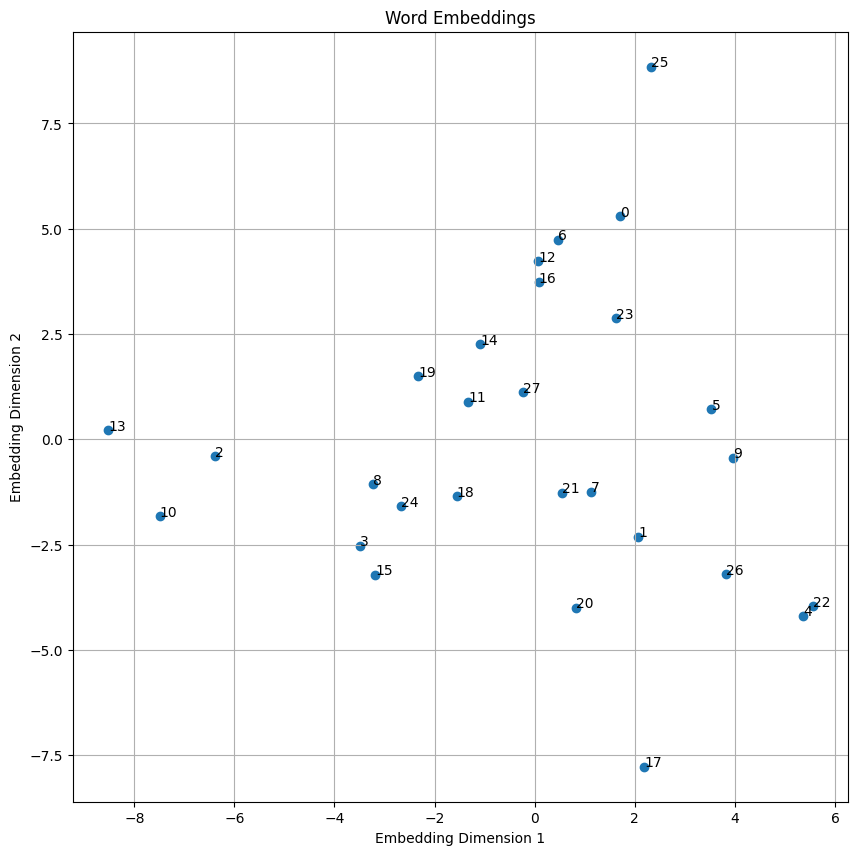

In [95]:
# Create a scatter plot of the embeddings
plt.figure(figsize=(10, 10))
plt.scatter(embeddings[:, 0], embeddings[:, 1])

# Annotate the points with their indices
for i in range(vocab_size):
    plt.annotate(i, (embeddings[i, 0], embeddings[i, 1]))

plt.title("Word Embeddings")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.grid(True)
plt.show()